In [1]:
import librosa
import librosa.display
import numpy as np
import soundfile as sf
from scipy.io.wavfile import write
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import warnings
import random
import logging
torch.cuda.empty_cache()
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from scipy.signal import spectrogram
from IPython.display import Audio

In [2]:
noise_folder = "data/noise/"
clean_folder = "data/clean/dev-clean"
output_folder = "data/noisy/"
denoising_folder = "data/denoising/"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)
os.makedirs(denoising_folder, exist_ok=True)

In [3]:
target_duration = 4 # 5sec

In [4]:
# Get the list of clean files
clean_path = []
for folder in os.listdir(clean_folder):
    folder_path = os.path.join(clean_folder, folder)
    if os.path.isdir(folder_path):
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.endswith(".flac"):
                    file_path = os.path.join(root, file)
                    clean_path.append(file_path)

In [5]:
clean_data = []
for clean_file in clean_path[:20]:
    s, sr = librosa.load(clean_file, sr=16000)
    target_length = target_duration * sr
    s = librosa.util.fix_length(s, size = target_length)
    clean_data.append(s)

len(clean_data)

20

In [6]:
s_rate = 16000

write("clean.wav", s_rate, s)

In [7]:
Audio("clean.wav")

In [8]:
# normalize the data
s_norm = preprocessing.normalize(s.reshape(1, -1), norm='max')

In [9]:
# scale the data
s_scale = scale(s_norm, axis=1, with_mean=True, with_std=True, copy=True)

In [10]:
# fourier transform
s_fft = librosa.stft(s_scale[0], n_fft=512, hop_length=256, win_length=512, window='hamming', center=True, pad_mode='reflect')

In [11]:
# convert to db
s_db = librosa.amplitude_to_db(np.abs(s_fft), ref=np.max)

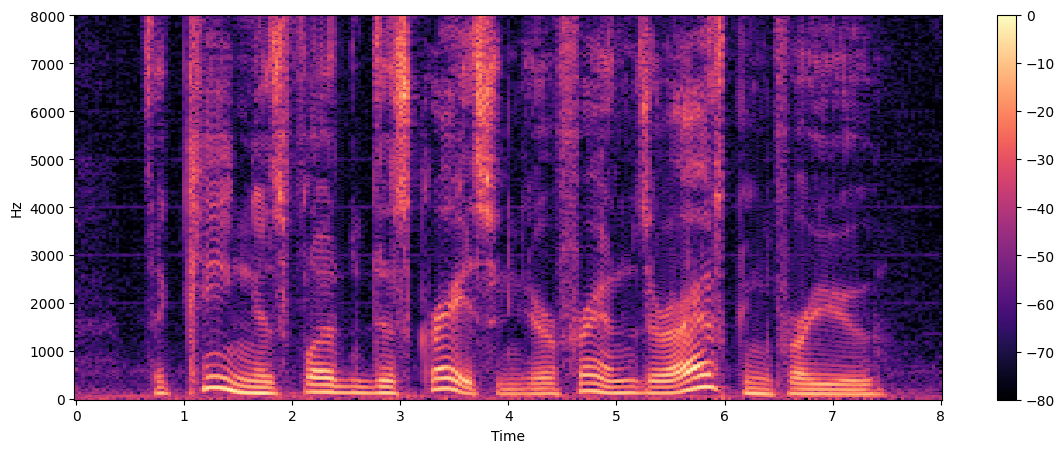

In [12]:
# plot the spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(s_db, sr=s_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.show()

In [13]:
# Get the list of noise files
noise_file = ""
if os.path.isdir(noise_folder):
        for root, dirs, files in os.walk(noise_folder):
            for file in files:
                if file.endswith(".wav"):
                    noise_file = os.path.join(root, file)

noise_file

'data/noise/babble_16k.wav'

In [14]:
# read noise file
u, ur = librosa.load(noise_file, sr=16000)

In [15]:
# adjust noise length
target_length = target_duration * ur
u = librosa.util.fix_length(u, size = target_length)

In [16]:
# save noise file
write("noise.wav", ur, u)

In [17]:
Audio("noise.wav")

In [18]:
# normalize the data
u_norm = preprocessing.normalize(u.reshape(1, -1), norm='max')

In [19]:
# scale the data
u_scale = scale(u_norm, axis=1, with_mean=True, with_std=True, copy=True)

In [20]:
# fourier transform
u_fft = librosa.stft(u_scale[0], n_fft=512, hop_length=256, win_length=512, window='hamming', center=True, pad_mode='reflect')

In [21]:
# convert to db
u_db = librosa.amplitude_to_db(np.abs(u_fft))

In [22]:
rsb = 6
alpha = 10**(-rsb/10)

x = s + alpha * u[:len(s)]

In [23]:
write(os.path.join('', "mixed.wav"), s_rate, x)

In [24]:
Audio(os.path.join('', "mixed.wav"))

In [25]:
# normalize the data
x_norm = preprocessing.normalize(x.reshape(1, -1), norm='max')

In [26]:
# scale the data
x_scale = scale(x_norm, axis=1, with_mean=True, with_std=True, copy=True)

In [27]:
# fourier transform
x_fft = librosa.stft(x_scale[0], n_fft=512, hop_length=256, win_length=512, window='hamming', center=True, pad_mode='reflect')

In [28]:
# convert to db
x_db = librosa.amplitude_to_db(np.abs(x_fft))

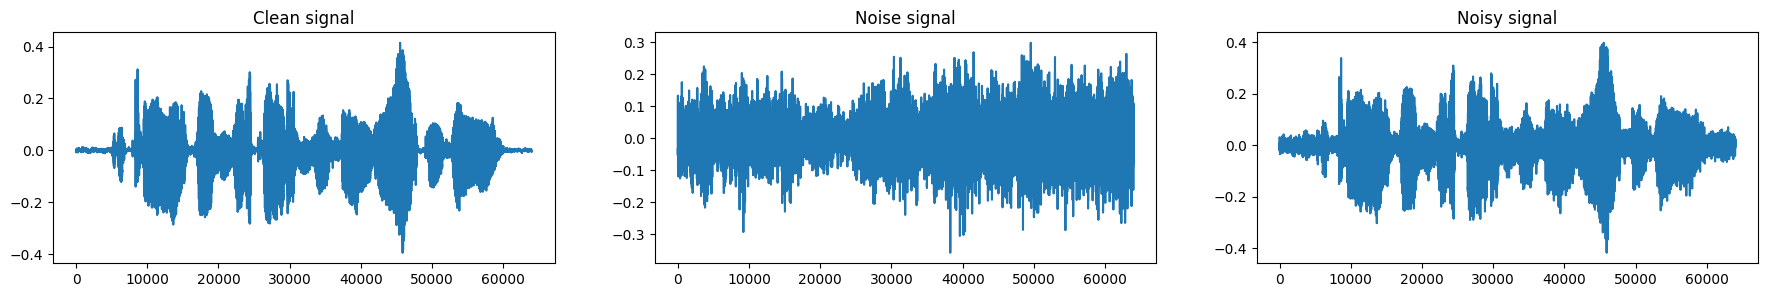

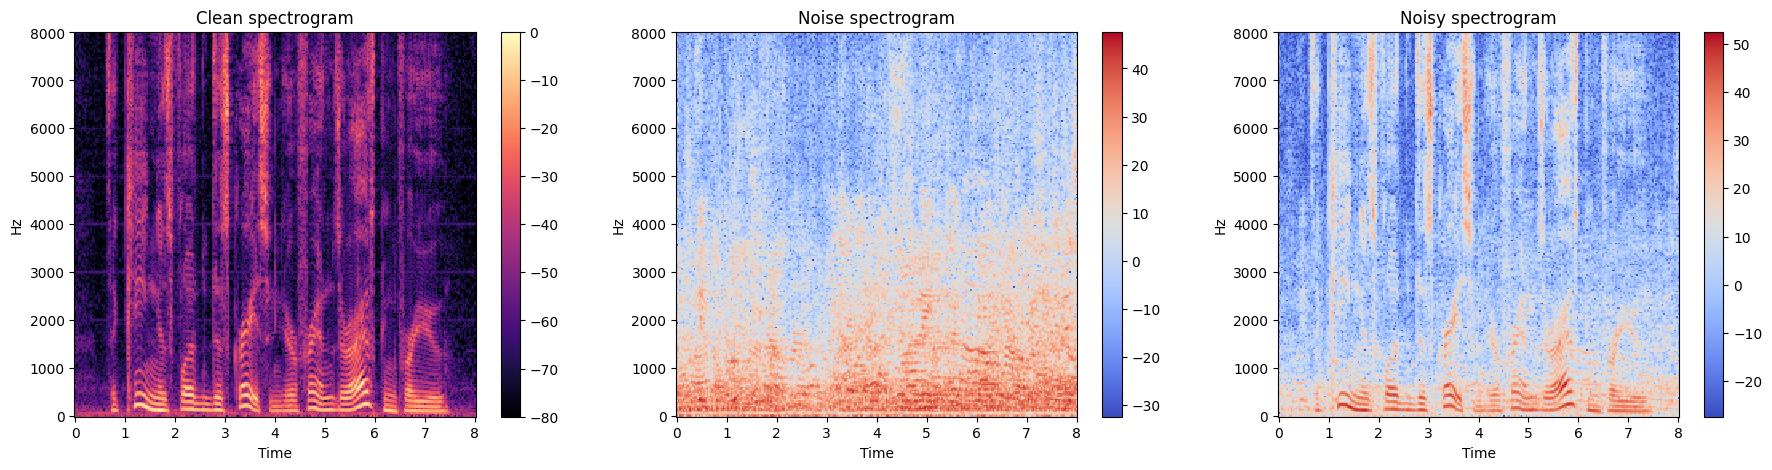

In [29]:
plt.figure(figsize=(22, 3))
plt.subplot(1, 3, 1)
plt.plot(s)
plt.title("Clean signal")
plt.subplot(1, 3, 2)
plt.plot(u)
plt.title("Noise signal")
plt.subplot(1, 3, 3)
plt.plot(x)
plt.title("Noisy signal")
plt.show()

plt.figure(figsize=(22, 5))
plt.subplot(1, 3, 1)
librosa.display.specshow(s_db, sr=s_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Clean spectrogram")
plt.subplot(1, 3, 2)
librosa.display.specshow(u_db, sr=s_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Noise spectrogram")
plt.subplot(1, 3, 3)
librosa.display.specshow(x_db, sr=s_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Noisy spectrogram")
plt.show()

In [30]:
len(clean_data)

20

In [31]:
class AudioDataset(Dataset):
    def __init__(self, clean_data, noise_file, rsb):
        self.clean_data = clean_data
        self.noise_file = noise_file
        self.clean_spec = []
        self.noise_spec = []
        self.noisy_spec = []
        self.rsb = rsb

    def __len__(self):
        return len(self.clean_data)

    def process(self):
        for idx in range(len(self.clean_data)):
            s = self.clean_data[idx]
            u, ur = librosa.load(self.noise_file, sr=16000)
            target_length = len(s)
            u = librosa.util.fix_length(u, size = target_length)
            alpha = 10**(-self.rsb/10)
            x = s + alpha * u[:len(s)]
            
            # save noisy file
            write(os.path.join(output_folder, "noisy_" + str(idx) + ".wav"), s_rate, x)
            
            # normalize the data
            s_norm = preprocessing.normalize(s.reshape(1, -1), norm='max')
            u_norm = preprocessing.normalize(u.reshape(1, -1), norm='max')
            x_norm = preprocessing.normalize(x.reshape(1, -1), norm='max')
            
            # scale the data
            s_scale = scale(s_norm, axis=1, with_mean=True, with_std=True, copy=True)
            u_scale = scale(u_norm, axis=1, with_mean=True, with_std=True, copy=True)
            x_scale = scale(x_norm, axis=1, with_mean=True, with_std=True, copy=True)
        
            # fourier transform
            s_fft = librosa.stft(s_scale[0], n_fft=512, hop_length=256, win_length=512, window='hamming', center=True, pad_mode='reflect')
            u_fft = librosa.stft(u_scale[0], n_fft=512, hop_length=256, win_length=512, window='hamming', center=True, pad_mode='reflect')
            x_fft = librosa.stft(x_scale[0], n_fft=512, hop_length=256, win_length=512, window='hamming', center=True, pad_mode='reflect')           
            
            # convert to db
            s_db = librosa.amplitude_to_db(np.abs(s_fft))
            u_db = librosa.amplitude_to_db(np.abs(u_fft))
            x_db = librosa.amplitude_to_db(np.abs(x_fft))
            
            self.clean_spec.append(s_db)
            self.noise_spec.append(u_db)
            self.noisy_spec.append(x_db)
            
    def __getitem__(self, idx):
        return self.clean_spec[idx], self.noise_spec[idx], self.noisy_spec[idx]

In [32]:
dataset = AudioDataset(clean_data, noise_file, rsb=6)
dataset.process()

In [33]:
s_db, u_db, x_db = dataset[0]

In [34]:
s_undb = librosa.db_to_amplitude(s_db)
s_istft = librosa.istft(s_undb, hop_length=256, win_length=512, window='hamming', center=True, length=len(s))
s_unscale = preprocessing.minmax_scale(s_istft, feature_range=(-1, 1), axis=0, copy=True)
            
write(os.path.join(".", "denoising.wav"), s_rate, s_unscale)

In [35]:
Audio(os.path.join(".", "denoising.wav"))

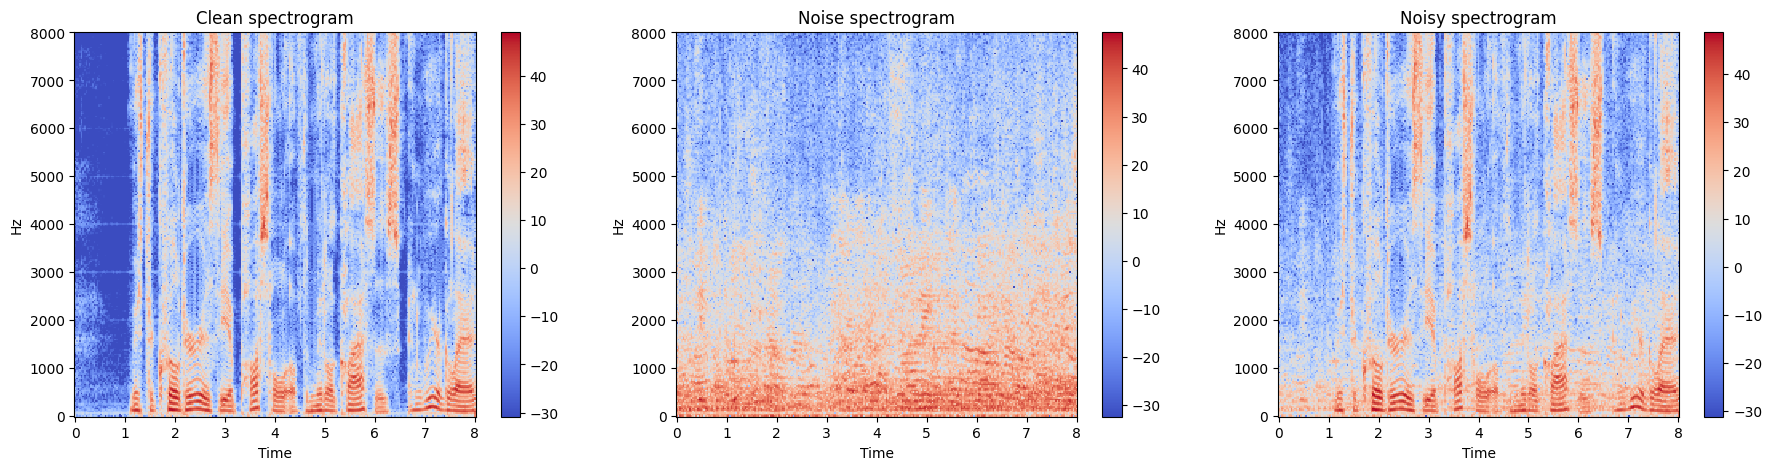

In [36]:
plt.figure(figsize=(22, 5))
plt.subplot(1, 3, 1)
librosa.display.specshow(s_db, sr=s_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Clean spectrogram")
plt.subplot(1, 3, 2)
librosa.display.specshow(u_db, sr=s_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Noise spectrogram")
plt.subplot(1, 3, 3)
librosa.display.specshow(x_db, sr=s_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Noisy spectrogram")
plt.show()

In [37]:
# check if all data has the same shape
for idx in range(len(dataset)):
    s_db, u_db, x_db = dataset[idx]
    print(s_db.shape, u_db.shape, x_db.shape)

(257, 251) (257, 251) (257, 251)
(257, 251) (257, 251) (257, 251)
(257, 251) (257, 251) (257, 251)
(257, 251) (257, 251) (257, 251)
(257, 251) (257, 251) (257, 251)
(257, 251) (257, 251) (257, 251)
(257, 251) (257, 251) (257, 251)
(257, 251) (257, 251) (257, 251)
(257, 251) (257, 251) (257, 251)
(257, 251) (257, 251) (257, 251)
(257, 251) (257, 251) (257, 251)
(257, 251) (257, 251) (257, 251)
(257, 251) (257, 251) (257, 251)
(257, 251) (257, 251) (257, 251)
(257, 251) (257, 251) (257, 251)
(257, 251) (257, 251) (257, 251)
(257, 251) (257, 251) (257, 251)
(257, 251) (257, 251) (257, 251)
(257, 251) (257, 251) (257, 251)
(257, 251) (257, 251) (257, 251)


In [38]:
def mask(clean, noise):
    binary_mask = np.where(clean ** 2 > noise ** 2, 1, 0)
    return binary_mask

In [39]:
class ModelDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.clean_spec = []
        self.noise_spec = []
        self.noisy_spec = []
        self.mask = []

    def __len__(self):
        return len(self.dataset)

    def process(self):
        for idx in range(len(self.dataset)):
            s_db, u_db, x_db = self.dataset[idx]
            m = mask(s_db, u_db)
            
            self.clean_spec.append(s_db)
            self.noise_spec.append(u_db)
            self.noisy_spec.append(x_db)
            self.mask.append(m)
            
    def __getitem__(self, idx):
        return self.clean_spec[idx], self.noise_spec[idx], self.noisy_spec[idx], self.mask[idx]

In [40]:
model_dataset = ModelDataset(dataset)
model_dataset.process()

In [41]:
s_db, u_db, x_db, m = model_dataset[0]

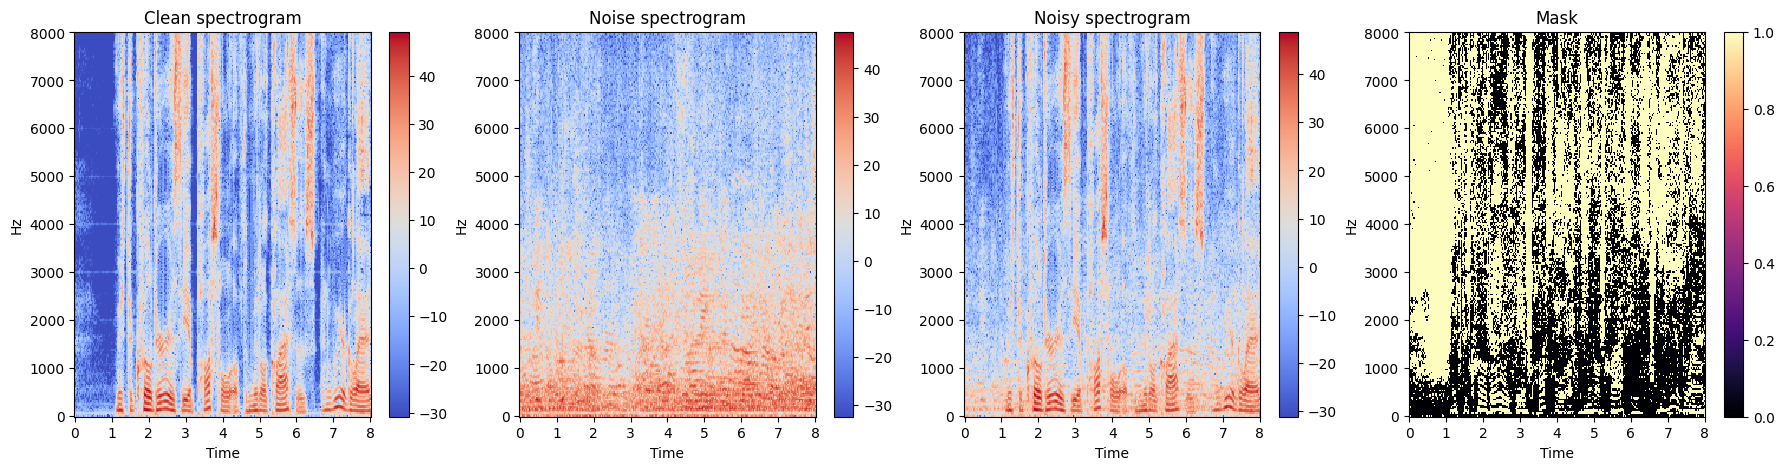

In [42]:
plt.figure(figsize=(22, 5))
plt.subplot(1, 4, 1)
librosa.display.specshow(s_db, sr=s_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Clean spectrogram")
plt.subplot(1, 4, 2)
librosa.display.specshow(u_db, sr=s_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Noise spectrogram")
plt.subplot(1, 4, 3)
librosa.display.specshow(x_db, sr=s_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Noisy spectrogram")
plt.subplot(1, 4, 4)
librosa.display.specshow(m, sr=s_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Mask")
plt.show()

In [43]:
clean_shape = model_dataset[0][0].shape
clean_shape

(257, 251)

In [44]:
noise_shape = model_dataset[0][1].shape
noise_shape

(257, 251)

In [45]:
noisy_shape = model_dataset[0][2].shape
noisy_shape

(257, 251)

In [46]:
mask_shape = model_dataset[0][3].shape
mask_shape

(257, 251)